RNN with pytorch
================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import torch
import gc
import pandas as pd
from time import perf_counter

from src.network import Network
from src.plot_utils import plot_con
from src.decode import decode_bump
from src.utils import clear_cache

REPO_ROOT = "/home/leon/models/NeuroTorch/"

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Documentation



Neurotorch is an implementation of a rate based recurrent neural network trainer and simulator.



### Simulation



#### Dynamics



##### Currents



Neuron $i$ in population $A$ has a reccurent input $h^A_i$,

$$  \tau_{syn} \frac{dh_i}{dt}(t) = - h_i(t) + \sum_j J_{ij} h_j(t) $$

or not

$$ h^A_i(t) = \sum_{jB} J^{AB}_{ij} h_j(t) $$



##### Rates



The models can have rate dynamics (setting **RATE<sub>DYN</sub>** to 1 in the configuration file):

$$ \tau_A \frac{d r^A_i}{dt}(t) = - r^A_i(t) + \Phi( \sum_{jB} J^{AB}_{ij} h^{AB}_j(t) + h^A_{ext}(t)) $$

\begin{equation}
\tau_A \frac{d r^A_i}{dt}(t) = - r^A_i(t) + \Phi( \sum_{jB} J^{AB}_{ij} h^{AB}_j(t) + h^A_{ext}(t))
\end{equation}

Here, $r_i$ is the rate of unit $i$ in population $A$

otherwise rates will be instantaneous:

\begin{equation}
  r^A_i(t) = \Phi(\sum_{jB} J^{AB}_{ij} h_j(t) + h^A_{ext}(t))
\end{equation}

Here $\Phi$ is the transfer function defined in **src/activation.py**



#### Connectivity



Probability of connection from population B to A:



##### Sparse Nets



by default it is a sparse net

\begin{equation}
P_{ij}^{AB} = \frac{K_B}{N_B}
\end{equation}

otherwise
it can be cosine

\begin{equation}
P_{ij}^{AB} = ( 1.0 + \KAPPA_B \cos(\theta_i^A - \theta_j^B) )
\end{equation}

and also low rank

\begin{equation}
  J_{ij}^{AB} = \frac{J_{AB}}{\sqrt{K_B}} with proba. P_{ij}^{AB} * \frac{K_B}{N_B} 
               0 otherwise
\end{equation}



##### All to all



\begin{equation}
  J_{ij}^{AB} =  \frac{J_{AB}}{N_B} P_{ij}^{AB}
\end{equation}

where Pij can be as above.



## RNN with torch



### Single Trial



Here we will run a single simulation with the parameters provided in config<sub>2pop.yml</sub>



In [1]:
start = perf_counter()

# First we create a network with
model = Network('config_2pop.yml', '', REPO_ROOT)

# then we run the simulation with
output = model()

print('output', output.shape)
# model outputs a tensor of rates of size (N_BATCH, N_STEPS, N_NEURON), so we need to convert it to numpy

rates = output[0].cpu().numpy()
print('rates', rates.shape)

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

Ne = model.Na[0].detach().cpu().numpy()
N = model.N_NEURON

output torch.Size([1, 101, 8000])
rates (101, 8000)
Elapsed (with compilation) = 0h 0m 6s

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

4124.75904
117.51936

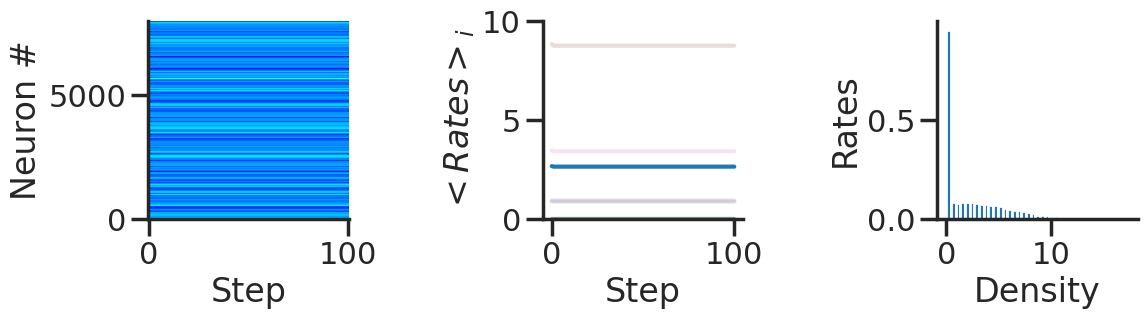

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(2*width, height))

r_max = 10

ax[0].imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Neuron #')
ax[0].set_xlabel('Step')

ax[1].plot(rates.mean(-1))
for i in range(10):
    ax[1].plot(rates[..., i], alpha=0.2)

ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, r_max])

ax[2].hist(rates[-1], density=True, bins='auto')
ax[2].set_xlabel('Density')
ax[2].set_ylabel('Rates')
plt.show()

### Multiple Trials



#### Multiple initial conditions



We can run multiple initializations of the network changing N<sub>BATCH</sub> to the number of initializations that we want.



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT, GAIN=5)

model.N_BATCH = 10
rates = model().cpu().numpy()
print('rates', rates.shape)

rates (10, 101, 8000)

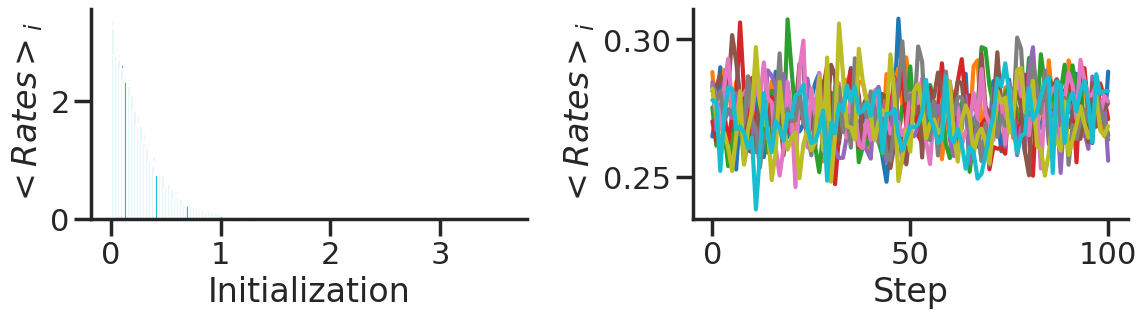

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

for i in range(rates.shape[0]):
    ax[0].hist(rates.mean(1)[i], bins='auto', density=True)
ax[0].set_ylabel('$<Rates>_i$')
ax[0].set_xlabel('Initialization')

ax[1].plot(rates.mean(-1).T)
ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
plt.show()

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

4124.75904
117.51936

#### Batching feedforward inputs



To run some parameter searches, we can easily batch over a different set of ff inputs
Let's see an example where we change the ff inputs to the excitatory population



##### The easy way (but memory consuming)



We create a batch of inputs of size (N<sub>BATCH</sub>, N<sub>STEPS</sub>, N<sub>NEURON</sub>)



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT)

ff_inputs = []
for i in range(10):
    model.Ja0[:, 0] = i  # here we set the ff input to E to value i in 0 .. 10
    ff_inputs.append(model.init_ff_input())

ff_inputs = torch.vstack(ff_inputs)
print('ff_inputs', ff_inputs.shape)

ff_inputs torch.Size([10, 11100, 10000])

Then we path these inputs to the model



In [1]:
rates = model(ff_inputs).cpu().numpy()
print(rates.shape)

(10, 101, 8000)

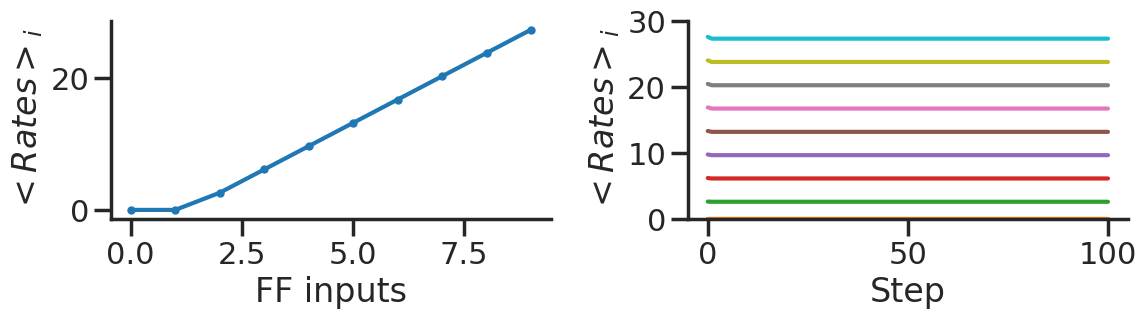

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(rates.mean((1,-1)), '-o')
ax[0].set_ylabel('$<Rates>_i$')
ax[0].set_xlabel('FF inputs')

ax[1].plot(rates.mean(-1).T)  
ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, 30])
plt.show()

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

48524.75904
44517.51936

##### The hard way (slow but more memory friendly)



We create a batch of ff inputs that are updated at each time step



In [1]:
model = Network('config_2pop.yml', '', REPO_ROOT)

N_BATCH = 10
print('original ff_input', model.Ja0.shape)

new_Ja0 = model.Ja0.repeat((N_BATCH, 2, 1))  
print('new ff_input', new_Ja0.shape)

new_Ja0[:, 0] = torch.linspace(0, 10, 10, device='cuda').unsqueeze(-1) * model.M0 * torch.sqrt(model.Ka[0])
print('batched ff_input', new_Ja0[:, 0].squeeze(-1))

original ff_input torch.Size([1, 2, 1])
new ff_input torch.Size([10, 4, 1])
batched ff_input tensor([  0.0000,  24.8452,  49.6904,  74.5356,  99.3808, 124.2260, 149.0712,
        173.9164, 198.7616, 223.6068], device='cuda:0')

In [1]:
model.N_BATCH = N_BATCH
model.Ja0 = new_Ja0
model.LIVE_FF_UPDATE = 1

start = perf_counter()
rates = model().cpu().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 9s
rates (10, 101, 8000)

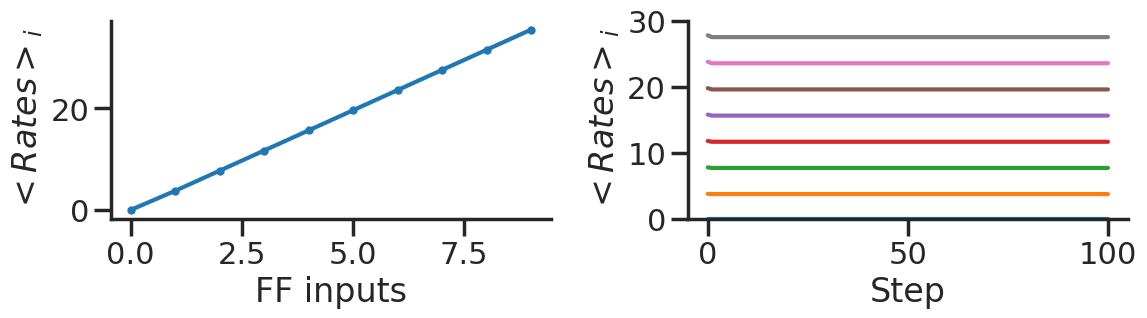

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(rates.mean((1,-1)), '-o')
ax[0].set_ylabel('$<Rates>_i$')
ax[0].set_xlabel('FF inputs')

ax[1].plot(rates.mean(-1).T)  
ax[1].set_ylabel('$<Rates>_i$')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, 30])
plt.show()

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

48531.15904
44517.52448

#### Batching Reccurent Weights Jab



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=0, DT=0.001, GAIN=0.5, VERBOSE=0)

In [1]:
model.IF_BATCH_J = 1

Jee_list = torch.linspace(0.0, 1.5, 10, device='cuda')  
model.Jab_batch = Jee_list.unsqueeze(-1) * model.Jab[0, 0]
print(model.Jab_batch[:, 0])

model.IF_STP = 1
model.N_BATCH = model.Jab_batch.shape[0]
model.VERBOSE = 0

tensor([0.0000, 0.0037, 0.0075, 0.0112, 0.0149, 0.0186, 0.0224, 0.0261, 0.0298,
        0.0335], device='cuda:0')

In [1]:
start = perf_counter()
rates_Jee = model().cpu().detach().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 24s
rates (10, 101, 8000)

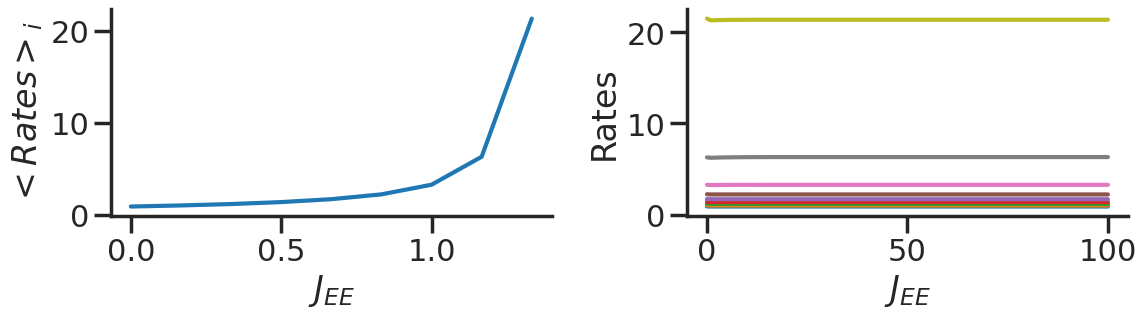

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_Jee[:,-1].mean(-1)

ax[0].plot(Jee_list.cpu().numpy(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$<Rates>_i$')
# ax[0].set_ylim([0, 60])

ax[1].plot(rates_Jee.mean(-1).T)
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('Rates')
# ax[1].set_ylim([0, 60])
plt.show()

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

53651.19488
44517.5296

#### Batching ff input and weights



In [1]:
model = Network('config_2pop.yml', 'None', REPO_ROOT, IF_STP=0, DT=0.001, GAIN=0.5, LIVE_FF_UPDATE=1)

In [1]:
N_BATCH = 10

JEE = torch.linspace(0.0, 5.0, N_BATCH, device='cuda')
JE0 = torch.linspace(0.0, 5.0, N_BATCH, device='cuda')

JEE = JEE.unsqueeze(1).expand(N_BATCH, N_BATCH) 
JEE = JEE.reshape((-1, 1)) * model.Jab[0, 0]
print('Jee', JEE.shape)

JE0 = JE0.unsqueeze(0).expand(N_BATCH, N_BATCH)
JE0 = JE0.reshape((-1, 1))
print('Je0', JE0.shape)

new_Ja0 = model.Ja0.repeat((N_BATCH*N_BATCH, 1, 1)) 

print('Ja0', new_Ja0.shape)
new_Ja0[:,0] = JE0 * torch.sqrt(model.Ka[0]) * model.M0

Jee torch.Size([100, 1])
Je0 torch.Size([100, 1])
Ja0 torch.Size([100, 2, 1])

In [1]:
print(JEE[:, 0].reshape(N_BATCH, N_BATCH)[0])
print(JEE[:, 0].reshape(N_BATCH, N_BATCH)[:, 0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.0000, 0.0124, 0.0248, 0.0373, 0.0497, 0.0621, 0.0745, 0.0870, 0.0994,
        0.1118], device='cuda:0')

In [1]:
print(new_Ja0[..., 0, 0].reshape(N_BATCH, N_BATCH)[0])
print(new_Ja0[..., 0, 0].reshape(N_BATCH, N_BATCH)[:, 0])

tensor([  0.0000,  12.4226,  24.8452,  37.2678,  49.6904,  62.1130,  74.5356,
         86.9582,  99.3808, 111.8034], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [1]:
model.IF_BATCH_J = 1
model.Jab_batch = JEE * model.Jab[0, 0]

model.Ja0 = new_Ja0

model.N_BATCH = model.Jab_batch.shape[0]
model.VERBOSE = 0

start = perf_counter()
rates = model().cpu().detach().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

print('rates', rates.shape)

Elapsed (with compilation) = 0h 1m 1s
rates (100, 101, 8000)

In [1]:
mean_rates = rates.mean(-1).reshape(N_BATCH, N_BATCH, -1)
print(mean_rates[0, :, -1])
print(mean_rates[:, 0, -1])

[1.4012985e-44 1.9618179e-44 1.6705768e-05 4.7168672e-01 1.0980070e+00
 1.7318970e+00 2.3675365e+00 3.0038698e+00 3.6404078e+00 4.2769861e+00]
[1.4e-44 1.4e-44 1.4e-44 1.4e-44 1.4e-44 1.4e-44 1.4e-44 1.4e-44 1.4e-44
 1.4e-44]

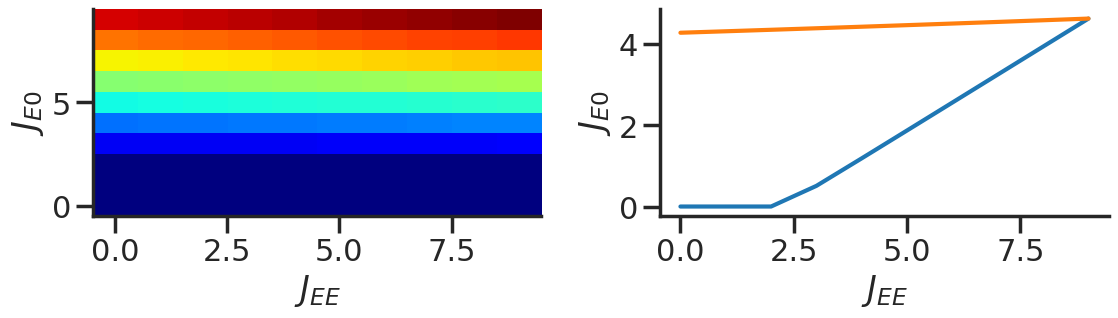

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(mean_rates[..., -1].T, cmap='jet', origin='lower', aspect='auto')
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$J_{E0}$')

ax[1].plot(mean_rates[-1, :, -1]) # over inputs
ax[1].plot(mean_rates[:, -1, -1]) # over Js

ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('$J_{E0}$')

plt.show()

In [1]:
print(torch.cuda.memory_allocated()/100000)
del model
clear_cache()
print(torch.cuda.memory_allocated()/100000)

51148.78464
44517.54496